In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb

The environment consists of 10 states numbered from 1 to 10, with 10 being the terminal state. The action space consists of going left, staying in the current state and going right. We let ```delta``` refer to the noise in the environment, which is a hyperparameter. 


**Instructions:**

Change the value of delta below to generate the plot for each noise level. 

In [3]:
# noise in environment 
delta = 0.8

# number of states
num_states = 10

# number of actions
num_actions = 3 # 1 for left, 2 for stay, 3 for right

**Expert Policy**

The expert's context length is 5. They will go right in every state other than state 5 where the expert will be idle unless the last five states were all state 5. 

In [4]:
def expert_policy(s_t, s_tminus1, s_tminus2, s_tminus3, s_tminus4, s_tminus5):
    if s_t == 1:
        return [3]
    if s_t == 2:
        return [3] 
    if s_t == 3:
        return [3]
    if s_t == 4:
        return [3]    
    if s_t == 5:
        if s_tminus1 == 5 and s_tminus2 == 5 and s_tminus3 == 5 and s_tminus4 == 5 and s_tminus5 == 5:
            return [3]
        else:
            return [2]
    if s_t == 6:
        return [3]
    if s_t == 7:
        return [3]    
    if s_t == 8:
        return [3]
    if s_t == 9:
        return [3]

**Data Collection**

We collect expert demonstrations. The demonstrations will be stored as ```trajectories``` which is a list containing tuples of the form ```(state visited, action taken)```

In [5]:
def collect_data():
    trajectories = []

    for i in range(1000):
        start = 1
        s_t = start
        s_tminus1 = start
        s_tminus2 = start
        s_tminus3 = start
        s_tminus4 = start
        s_tminus5 = start
        
        trajectory = []
        current_state = start
    
        while current_state < 10:
            actions = expert_policy(s_t, s_tminus1, s_tminus2, s_tminus3, s_tminus4, s_tminus5)
            
            for a_t in actions:
                trajectory.append((current_state, a_t))
                if a_t == 1:
                    if np.random.rand() <= (1 - delta):
                        current_state -= 1
                    elif np.random.rand() < (1 - delta) + (delta)/2:
                        current_state = current_state
                    else:
                        current_state += 1
                
                if a_t == 3:
                    if np.random.rand() <= (1 - delta):
                        current_state += 1
                    else:
                        current_state = current_state

                if a_t == 2:
                    if np.random.rand() < (1 - delta):
                        current_state = current_state
                    else:
                        current_state += 1

            s_tminus5 = s_tminus4
            s_tminus4 = s_tminus3
            s_tminus3 = s_tminus2
            s_tminus2 = s_tminus1
            s_tminus1 = s_t
            s_t = current_state
            
        
        trajectories.append(trajectory)
    
    return trajectories

trajectories = collect_data()

Preprocess the data:

We add ten ```(1, 2)```'s to the beginning and ten ```(10, 2)```'s at the end of each trajectory. This makes implementing the context dependency of agents' actions easier. 

In [6]:
# for each trajecotry in trajectories, add ten 1s at the beginning and ten 10s at the end
for i in range(len(trajectories)):
    trajectories[i] = [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2)] + trajectories[i] + [(10, 2), (10, 2), (10, 2), (10, 2), (10, 2), (10, 2), (10, 2), (10, 2), (10, 2), (10, 2)]

Now, we let our expert act in the environment 100 times. The expert keeps taking actions until it reaches the terminal state, state 10. We count the number of times idle actions, i.e. action 2, were taken in each episode.

In [7]:
def increment_count(action, idle_counts, idle_count, current_state):
    if action == 2:
        try:
            idle_counts[current_state - 1] += 1 
            idle_count += 1
        except:
            ipdb.set_trace()
        if np.random.rand() < 1 - delta:
            current_state = current_state
        else:
            current_state += 1

    if action == 1:
        if np.random.rand() <= 1 - delta:
            current_state -= 1
        elif np.random.rand() < 1 - delta + (1 - (1 - delta))/2:
            current_state = current_state
        else:
            current_state += 1
        
    if action == 3:
        if np.random.rand() <= (1 - delta):
            current_state += 1
        else:
            current_state = current_state

    return idle_counts, idle_count, current_state

def act():

    '''
    iterate over 100 episodes. 
    For each episode, start at state 1 and follow the policy generated by the expert until the end of the game at state 10
    For each episode, keep a record of the states at which the agent took action 2 (stay) and the number of times it took action 2 at each state 
    
    '''

    idle_counts = np.zeros(num_states)
    idle_counts_nums = []

    for i in range(100):
        current_state = 1
        s_t = 1
        s_tminus1 = 1
        s_tminus2 = 1
        s_tminus3 = 1
        s_tminus4 = 1
        s_tminus5 = 1
        

        idle_count = 0
        while current_state < 10:
            actions = expert_policy(s_t, s_tminus1, s_tminus2, s_tminus3, s_tminus4, s_tminus5)
            
            for a_t in actions:
                idle_counts, idle_count, current_state = increment_count(a_t, idle_counts, idle_count, current_state)
            
            s_tminus5 = s_tminus4
            s_tminus4 = s_tminus3
            s_tminus3 = s_tminus2
            s_tminus2 = s_tminus1
            s_tminus1 = s_t
            s_t = current_state

            if current_state >= 10 or current_state <= 0:
                break
        
        idle_counts_nums.append(idle_count)

    return idle_counts/100, idle_counts_nums

idle_counts_expert, idle_counts_nums_expert = act()
print(idle_counts_expert)
print(idle_counts_nums_expert)

[0.   0.   0.   0.   1.31 0.   0.   0.   0.   0.  ]
[1, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


Define a policy with context length = 1 and action horizon = AH. The policy models the joint distribution of the next AH actions conditioned on the current state observation. 

In [8]:
def generate_policy(trajectories, s_t, AH):
    ''' 
    Define the policy with action horizon = 1 and context length = 

    '''
    actions = []

    for trajectory in trajectories:
        for i in range(10, len(trajectory) - AH):
            if trajectory[i][0] == s_t:
                    action = []
                    for j in range(AH):
                        action.append(trajectory[i+j][1])
                    actions.append(action)

    
    if len(actions) == 0:
        print('Random action')
        # make a random distribution that sums to 1
        action_distribution = np.random.rand(num_actions, AH)
        action_distribution = action_distribution / np.sum(action_distribution, axis=0)

    else:
        try: 
            action_distribution = np.zeros((num_actions, AH))
            for action in actions:
                for j in range(AH):
                    action_distribution[action[j]-1][j] += 1
            
            action_distribution = action_distribution / np.sum(action_distribution, axis=0)
        except:
            ipdb.set_trace()
    
    return action_distribution

policy_cache = {}
def get_policy(s_t, AH):
    ''' 
    Store the action distribution for a given state s_t to avoid recomputing it
    '''
    if (s_t) in policy_cache:
        return policy_cache[(s_t)]
    policy = generate_policy(trajectories, s_t, AH)
    policy_cache[(s_t)] = policy
    return policy

def act(AH):
    ''' 
    Agent acts in the environment. 
    Iterate over 100 episodes. 
    For each episode, start at state 1 and follow the policy generated by the expert until the end of the game at state 10
    For each episode, keep a record of the states at which the agent took action 2 (stay) and the number of times it took action 2 at each state 
    '''

    idle_counts = np.zeros(num_states)
    idle_counts_nums = []

    for i in range(100):
        current_state = 1
        s_t = 1
        s_tminus1 = 1
        s_tminus2 = 1
        s_tminus3 = 1
        idle_count = 0
        while current_state < 10:
            policy = get_policy(s_t, AH)
            actions = []

            for i in range(AH):
                actions.append(np.random.choice([1, 2, 3], p=policy[:,i]))
            
            for a_t in actions: 
                idle_counts, idle_count, current_state = increment_count(a_t, idle_counts, idle_count, current_state)
                s_tminus3 = s_tminus2
                s_tminus2 = s_tminus1
                s_tminus1 = s_t
                s_t = current_state
                if current_state >= 10 or current_state <= 0:
                    break
        
        idle_counts_nums.append(idle_count)

    return idle_counts/100, idle_counts_nums

**Agent with action horizon = 1, context length = 1**

Agent generates only one action based on the current observation. 

In [9]:
policy_cache = {}
idle_counts_1, idle_counts_nums_1 = act(1)
print(idle_counts_1)
print(idle_counts_nums_1)

[0.   0.   0.   0.   1.25 0.   0.   0.   0.   0.  ]
[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]


**Agent with action horizon = 3, context length = 1**

Agent generates 3 actions based on the current observation. 

In [10]:
policy_cache = {}
idle_counts_3, idle_counts_nums_3 = act(3)
print(idle_counts_3)
print(idle_counts_nums_3)

[0.   0.   0.05 0.4  0.93 0.16 0.02 0.03 0.38 0.  ]
[2, 3, 1, 2, 2, 0, 2, 1, 2, 4, 2, 1, 2, 1, 3, 4, 1, 2, 1, 1, 2, 3, 2, 1, 2, 4, 4, 0, 2, 1, 2, 4, 3, 0, 2, 2, 1, 2, 2, 1, 3, 1, 3, 0, 1, 4, 2, 3, 3, 3, 3, 1, 4, 1, 2, 2, 1, 2, 1, 3, 4, 3, 1, 0, 2, 2, 2, 3, 2, 2, 3, 3, 4, 2, 3, 3, 1, 2, 5, 1, 2, 1, 1, 1, 0, 3, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 3, 1, 3]


**Agent with action horizon = 4, context length = 1**

Agent generates 4 actions based on the current observation. 

In [11]:
policy_cache = {}
idle_counts_4, idle_counts_nums_4 = act(4)
print(idle_counts_4)
print(idle_counts_nums_4)

[0.   0.01 0.06 0.32 0.85 0.12 0.04 0.07 0.56 0.  ]
[1, 0, 1, 3, 4, 2, 0, 3, 1, 1, 2, 2, 1, 3, 1, 2, 1, 3, 2, 2, 5, 1, 5, 2, 3, 3, 2, 3, 2, 1, 3, 4, 3, 3, 2, 2, 3, 1, 5, 1, 2, 2, 3, 3, 1, 2, 3, 2, 3, 2, 3, 1, 2, 2, 2, 0, 3, 1, 1, 2, 1, 5, 2, 3, 2, 1, 3, 1, 2, 2, 0, 2, 2, 2, 2, 3, 2, 0, 1, 2, 1, 3, 1, 3, 1, 0, 2, 0, 2, 2, 2, 2, 1, 2, 3, 3, 2, 2, 2, 2]


**Agent with action horizon = 5, context length = 1**

Agent generates 5 actions based on the current observation. 

In [12]:
policy_cache = {}
idle_counts_5, idle_counts_nums_5 = act(5)
print(idle_counts_5)
print(idle_counts_nums_5)

[0.   0.01 0.14 0.36 0.8  0.18 0.03 0.15 0.54 0.  ]
[2, 2, 3, 1, 1, 2, 0, 2, 0, 2, 2, 4, 4, 1, 3, 2, 4, 0, 3, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 3, 3, 2, 3, 1, 1, 2, 2, 2, 3, 3, 1, 3, 2, 5, 2, 1, 4, 1, 3, 6, 2, 2, 2, 1, 1, 3, 2, 4, 3, 1, 2, 3, 2, 0, 2, 4, 2, 4, 1, 2, 1, 1, 4, 1, 1, 2, 3, 1, 3, 2, 5, 4, 2, 2, 3, 4, 2, 4, 2, 2, 1, 2, 1, 4, 2, 4, 2, 2, 2, 3]


**Agent with action horizon = 7, context length = 1**

Agent generates 7 actions based on the current observation. 

In [13]:
policy_cache = {}
idle_counts_7, idle_counts_nums_7 = act(7)
print(idle_counts_7)
print(idle_counts_nums_7)

[0.01 0.01 0.13 0.3  0.66 0.25 0.11 0.14 0.56 0.  ]
[3, 2, 5, 3, 3, 2, 1, 2, 2, 5, 1, 2, 2, 3, 1, 3, 1, 1, 2, 2, 3, 3, 1, 1, 3, 0, 3, 1, 2, 7, 5, 3, 2, 3, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 3, 2, 0, 5, 4, 1, 1, 2, 2, 4, 3, 0, 2, 2, 3, 1, 3, 1, 6, 3, 3, 1, 3, 3, 2, 2, 5, 2, 2, 2, 3, 2, 1, 0, 1, 3, 3, 3, 0, 2, 3, 4, 1, 0, 1, 2, 2, 1, 3, 2, 2, 1, 1, 4, 1, 1]


**Agent with action horizon = 10, context length = 1**

Agent generates 10 actions based on the current observation. 

In [14]:
policy_cache = {}
idle_counts_10, idle_counts_nums_10 = act(10)
print(idle_counts_10)
print(idle_counts_nums_10)

[0.03 0.08 0.21 0.31 0.64 0.21 0.15 0.31 0.61 0.  ]
[2, 2, 2, 2, 3, 0, 7, 2, 4, 2, 4, 0, 1, 1, 3, 2, 6, 2, 2, 2, 5, 3, 5, 4, 1, 4, 2, 2, 2, 1, 2, 1, 2, 5, 2, 2, 3, 2, 3, 3, 0, 3, 2, 3, 2, 5, 3, 2, 3, 3, 3, 4, 1, 2, 0, 3, 2, 1, 2, 2, 7, 3, 2, 4, 5, 4, 5, 2, 1, 1, 5, 2, 3, 3, 0, 3, 2, 2, 5, 2, 1, 2, 2, 1, 3, 5, 2, 2, 2, 1, 4, 1, 3, 1, 1, 2, 4, 3, 2, 3]


**Plots**

Noise = 0.8


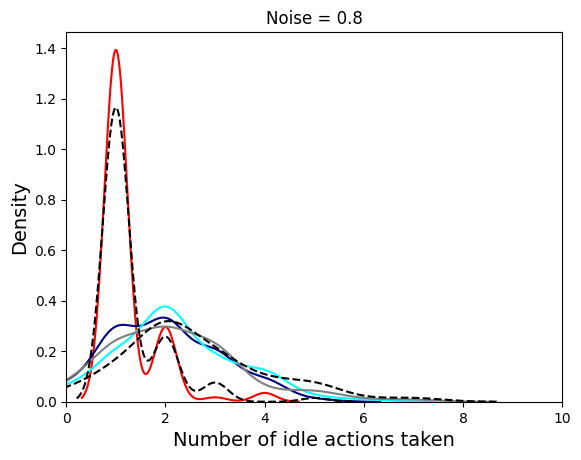

In [15]:
# calculate total variation distance between the distributions and expert policy
import seaborn as sns
import scipy.stats as stats


print(f'Noise = {delta}')
# Total Variation Distance between Action Horizon = 1 and Expert Policy:
TVD1 = stats.wasserstein_distance(idle_counts_nums_1, idle_counts_nums_expert)
# Total Variation Distance between Action Horizon = 3 and Expert Policy:
TVD3 = stats.wasserstein_distance(idle_counts_nums_3, idle_counts_nums_expert)
# Total Variation Distance between Action Horizon = 5 and Expert Policy:
TVD5 = stats.wasserstein_distance(idle_counts_nums_5, idle_counts_nums_expert)
# Total Variation Distance between Action Horizon = 7 and Expert Policy:
TVD7 = stats.wasserstein_distance(idle_counts_nums_7, idle_counts_nums_expert)
# Total Variation Distance between Action Horizon = 10 and Expert Policy:
TVD10 = stats.wasserstein_distance(idle_counts_nums_10, idle_counts_nums_expert)
            
# Plotting KDEs
sns.kdeplot(idle_counts_nums_1, color = 'red', label='Action Horizon = 1', fill=False)
sns.kdeplot(idle_counts_nums_3, color = 'navy', label='Action Horizon = 3', fill=False)
sns.kdeplot(idle_counts_nums_5, color = 'cyan', label='Action Horizon = 5', fill=False)
sns.kdeplot(idle_counts_nums_7, color = 'grey', label='Action Horizon = 7', fill=False)
sns.kdeplot(idle_counts_nums_10, color = 'black', linestyle='--', label='Action Horizon = 10', fill=False)
sns.kdeplot(idle_counts_nums_expert, label='Expert Policy', color = 'black', linestyle='--', fill=False)

if TVD10 == 0:
    plt.axvline(np.mean(idle_counts_nums_10), color = 'orange') 

if np.std(idle_counts_nums_10) == 0:
    plt.axvline(np.mean(idle_counts_nums_expert), color='black', linestyle='--')  


# plt.legend([f'Action Horizon = 1, TVD = {TVD1}', f'Action Horizon = 3, TVD = {TVD3}', f'Action Horizon = 5, TVD = {TVD5}', f'Action Horizon = 7, TVD = {TVD7}', f'Action Horizon = 10, TVD = {TVD10}', 'Expert Policy'], fontsize=10)
plt.xlabel('Number of idle actions taken', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(0, 10)
plt.title(f"Noise = {delta}")
plt.show()

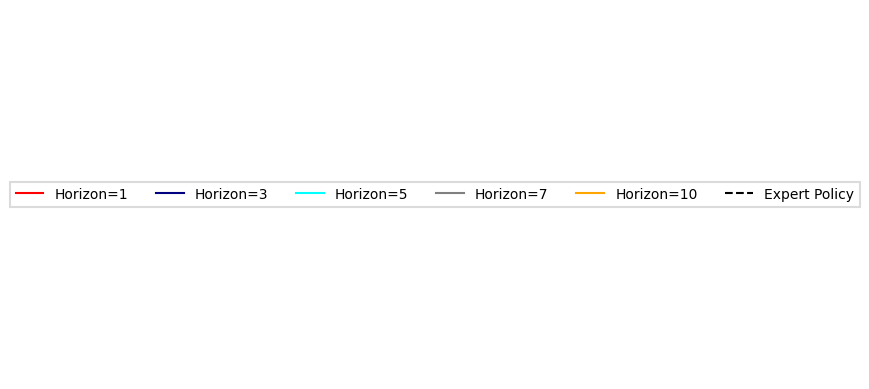

In [16]:
# Create an empty figure
fig, ax = plt.subplots()

# Dummy lines for the legend
line1, = ax.plot([], [], color='red', label='Horizon=1')
line2, = ax.plot([], [], color='navy', label='Horizon=3')
line3, = ax.plot([], [], color='cyan', label='Horizon=5')
line4, = ax.plot([], [], color='gray', label='Horizon=7')
line5, = ax.plot([], [], color='orange', label='Horizon=10')
line6, = ax.plot([], [], linestyle='--', color='black', label='Expert Policy')


legend = ax.legend(loc='center', frameon=True, ncol=6, fancybox=False, edgecolor='lightgray')
legend.get_frame().set_linewidth(1.5)
ax.axis('off')

plt.show()

In [17]:
# Print the TVDs
print(f'Total Variation Distance between Action Horizon = 1 and Expert Policy: {TVD1}')
print(f'Total Variation Distance between Action Horizon = 3 and Expert Policy: {TVD3}')
print(f'Total Variation Distance between Action Horizon = 5 and Expert Policy: {TVD5}')
print(f'Total Variation Distance between Action Horizon = 7 and Expert Policy: {TVD7}')
print(f'Total Variation Distance between Action Horizon = 10 and Expert Policy: {TVD10}')

Total Variation Distance between Action Horizon = 1 and Expert Policy: 0.08000000000000007
Total Variation Distance between Action Horizon = 3 and Expert Policy: 0.8
Total Variation Distance between Action Horizon = 5 and Expert Policy: 1.02
Total Variation Distance between Action Horizon = 7 and Expert Policy: 1.0
Total Variation Distance between Action Horizon = 10 and Expert Policy: 1.34


In [20]:
import pandas as pd

# Create a dataframe with the idle counts
df = pd.DataFrame({
    'Action Horizon = 1': idle_counts_nums_1,
    'Action Horizon = 3': idle_counts_nums_3,
    'Action Horizon = 5': idle_counts_nums_5,
    'Action Horizon = 7': idle_counts_nums_7,
    'Action Horizon = 10': idle_counts_nums_10,
    'Expert Policy': idle_counts_nums_expert
})

# Create a dataframe with the TVDs
df2 = pd.DataFrame({
    'Action Horizon': [1, 3, 5, 7, 10],
    'TVD': [TVD1, TVD3, TVD5, TVD7, TVD10]
})

# Print the dataframes
print(df)
print(df2)

    Action Horizon = 1  Action Horizon = 3  Action Horizon = 5  \
0                    1                   2                   2   
1                    2                   3                   2   
2                    1                   1                   3   
3                    1                   2                   1   
4                    1                   2                   1   
..                 ...                 ...                 ...   
95                   1                   2                   4   
96                   1                   1                   2   
97                   1                   3                   2   
98                   2                   1                   2   
99                   2                   3                   3   

    Action Horizon = 7  Action Horizon = 10  Expert Policy  
0                    3                    2              1  
1                    2                    2              1  
2                    5  